In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("online_retail.csv")
print("✅ Dataset loaded successfully!")
df.columns = df.columns.str.lower().astype(str)


✅ Dataset loaded successfully!


In [2]:
print("📊 Displaying dataset information:")
print(df.info())

📊 Displaying dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoiceno    541909 non-null  object 
 1   stockcode    541909 non-null  object 
 2   description  540455 non-null  object 
 3   quantity     541909 non-null  int64  
 4   invoicedate  541909 non-null  object 
 5   unitprice    541909 non-null  float64
 6   customerid   406829 non-null  float64
 7   country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [5]:
print("First 5 rows of the dataset:")
print(df.head(2))

First 5 rows of the dataset:
  invoiceno stockcode                         description  quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   

           invoicedate  unitprice  customerid         country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [8]:
print("Number of duplicated rows:")
print(df.duplicated().sum())

if df.duplicated().sum() == 0:
    print("No need to remove duplicates.")
else:
    df.drop_duplicates(inplace=True)

print("Number of duplicated rows after removal:")
print(df.duplicated().sum())


Number of duplicated rows:
5268
Number of duplicated rows after removal:
0


In [11]:
from datetime import timedelta

snapshot_date = df['invoicedate'].max() + timedelta(days=1)

rfm = df.groupby('customerid').agg({
    'invoicedate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'invoiceno': 'nunique',                                  # Frequency
    'TotalPrice': 'sum'                                      # Monetary
}).reset_index()
rfm.rename(columns={
    'invoicedate': 'Recency',
    'invoiceno': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

# Average Order Value (متوسط الإنفاق لكل عملية)
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

# Customer Tenure (عدد الأيام بين أول وآخر عملية)
tenure = df.groupby('customerid')['invoicedate'].agg(['min', 'max'])
tenure['Customer_Tenure'] = (tenure['max'] - tenure['min']).dt.days
rfm = rfm.merge(tenure['Customer_Tenure'], on='customerid', how='left')

# Total Quantity Purchased (إجمالي القطع)
total_qty = df.groupby('customerid')['quantity'].sum().rename('Total_Quantity')
rfm = rfm.merge(total_qty, on='customerid', how='left')

# Normalized RFM Scores (درجات من 1 لـ5)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# RFM Total Score
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

df['invoicedate'] = pd.to_datetime(df['invoicedate'], errors='coerce')
df = df.dropna(subset=['customerid'])
df = df[~df['invoiceno'].astype(str).str.startswith('C')]
df = df[(df['quantity'] > 0) & (df['unitprice'] > 0)]
df['TotalPrice'] = df['quantity'] * df['unitprice']

print("✅ Extra features added successfully!")
display(rfm.head())

✅ Extra features added successfully!


,customerid,Recency,Frequency,Monetary,AOV,Customer_Tenure,Total_Quantity,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,1,77183.60,77183.600000,0,74215,1,1,5,7
1,12347.0,2,7,4310.00,615.714286,365,2458,5,5,5,15
2,12348.0,75,4,1797.24,449.310000,282,2341,2,4,4,10
3,12349.0,19,1,1757.55,1757.550000,0,631,4,1,4,9
4,12350.0,310,1,334.40,334.400000,0,197,1,1,2,4


In [12]:
def segment_customer(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    if (r >= 4) and (f >= 4) and (m >= 4):
        return 'Champions'
    elif (r >= 3) and (f >= 4):
        return 'Loyal Customers'
    elif (r >= 3) and (f >= 2):
        return 'Potential Loyalists'
    elif (r == 2) and (f >= 2):
        return 'At Risk'
    elif (r == 1):
        return 'Lost'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Customer_Count']
display(segment_counts)

marketing_ideas = {
    'Champions': 'Offer exclusive discounts or VIP deals.',
    'Loyal Customers': 'Reward them with loyalty points or free shipping.',
    'Potential Loyalists': 'Provide small discounts to encourage repeat purchases.',
    'At Risk': 'Send re-engagement campaigns or discount coupons.',
    'Lost': 'Try win-back emails or introduce new products.',
    'Others': 'Monitor their activity for future targeting.'
}

rfm['Marketing_Advice'] = rfm['Segment'].map(marketing_ideas)

print("Segmentation and marketing suggestions added.")
display(rfm[['customerid', 'Segment', 'Marketing_Advice']].head(10))


,Segment,Customer_Count
0,Champions,957
1,Lost,865
2,Potential Loyalists,865
3,At Risk,644
4,Others,504
5,Loyal Customers,503


Segmentation and marketing suggestions added.


,customerid,Segment,Marketing_Advice
0,12346.0,Lost,Try win-back emails or introduce new products.
1,12347.0,Champions,Offer exclusive discounts or VIP deals.
2,12348.0,At Risk,Send re-engagement campaigns or discount coupons.
3,12349.0,Others,Monitor their activity for future targeting.
4,12350.0,Lost,Try win-back emails or introduce new products.
5,12352.0,Loyal Customers,Reward them with loyalty points or free shipping.
6,12353.0,Lost,Try win-back emails or introduce new products.
7,12354.0,Lost,Try win-back emails or introduce new products.
8,12355.0,Lost,Try win-back emails or introduce new products.
9,12356.0,Potential Loyalists,Provide small discounts to encourage repeat pu...


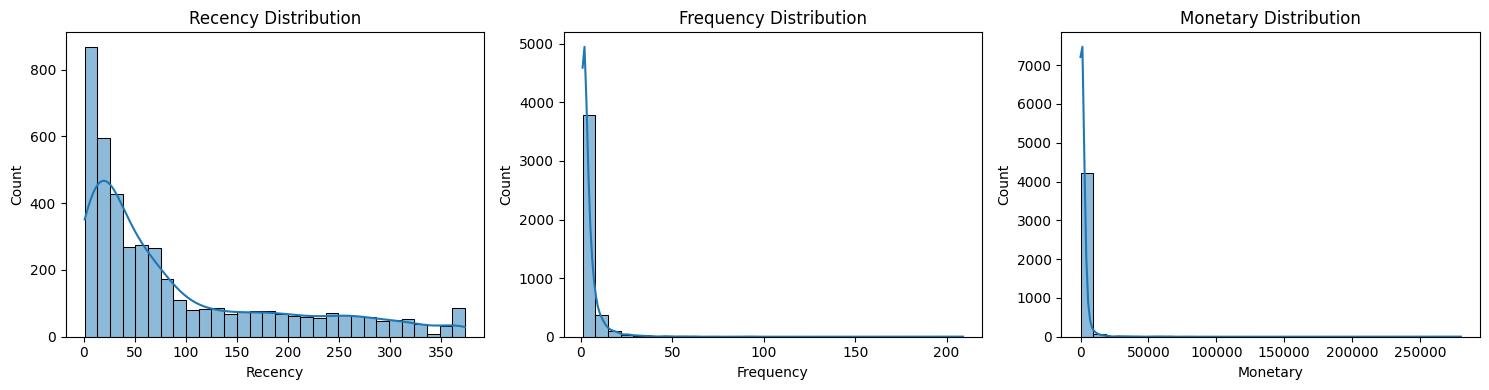

C:\Users\ziyad\AppData\Local\Temp\ipykernel_25876\78447359.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')


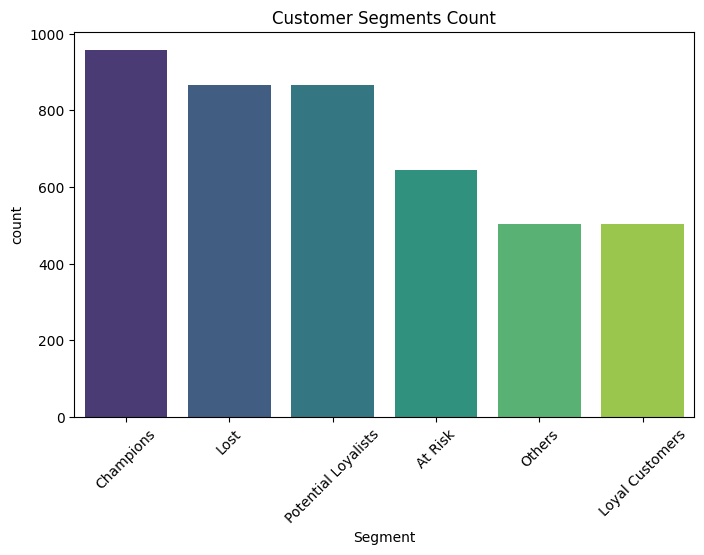

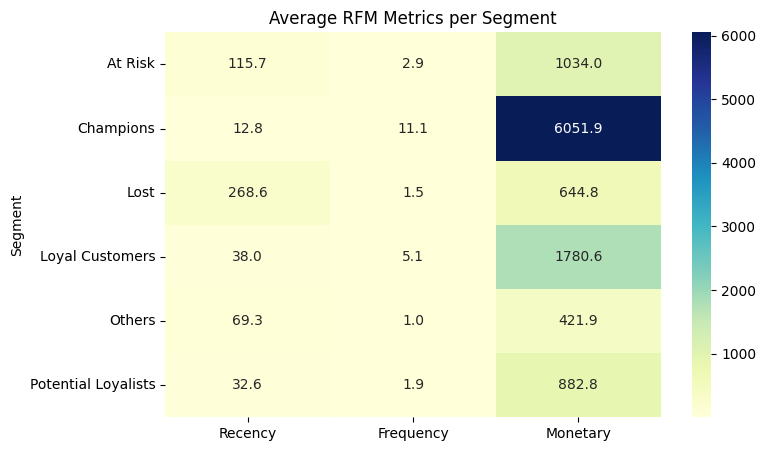

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30, kde=True)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=30, kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title('Customer Segments Count')
plt.xticks(rotation=45)
plt.show()

rfm_segment_avg = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
plt.figure(figsize=(8, 5))
sns.heatmap(rfm_segment_avg, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Average RFM Metrics per Segment')
plt.show()


In [15]:
df.to_csv("Online Retail Processed.csv", index=False)
print("✅ Cleaned Dataset saved successfully")

✅ Cleaned Dataset saved successfully
